In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [245]:
df = pd.read_csv('marketing_sample_for_naukri_com-jobs__20190701_20190830__30k_data.csv')
df.head()

,Uniq Id,Crawl Timestamp,Job Title,Job Salary,Job Experience Required,Key Skills,Role Category,Location,Functional Area,Industry,Role
0,9be62c49a0b7ebe982a4af1edaa7bc5f,2019-07-05 01:46:07 +0000,Digital Media Planner,Not Disclosed by Recruiter,5 - 10 yrs,Media Planning| Digital Media,Advertising,Mumbai,"Marketing , Advertising , MR , PR , Media Plan...","Advertising, PR, MR, Event Management",Media Planning Executive/Manager
1,3c52d436e39f596b22519da2612f6a56,2019-07-06 08:04:50 +0000,Online Bidding Executive,Not Disclosed by Recruiter,2 - 5 yrs,pre sales| closing| software knowledge| clien...,Retail Sales,"Pune,Pune","Sales , Retail , Business Development","IT-Software, Software Services",Sales Executive/Officer
2,ffad8a2396c60be2bf6d0e2ff47c58d4,2019-08-05 15:50:44 +0000,Trainee Research/ Research Executive- Hi- Tec...,Not Disclosed by Recruiter,0 - 1 yrs,Computer science| Fabrication| Quality check|...,R&D,Gurgaon,"Engineering Design , R&D","Recruitment, Staffing",R&D Executive
3,7b921f51b5c2fb862b4a5f7a54c37f75,2019-08-05 15:31:56 +0000,Technical Support,"2,00,000 - 4,00,000 PA.",0 - 5 yrs,Technical Support,Admin/Maintenance/Security/Datawarehousing,Mumbai,"IT Software - Application Programming , Mainte...","IT-Software, Software Services",Technical Support Engineer
4,2d8b7d44e138a54d5dc841163138de50,2019-07-05 02:48:29 +0000,Software Test Engineer -hyderabad,Not Disclosed by Recruiter,2 - 5 yrs,manual testing| test engineering| test cases|...,Programming & Design,Hyderabad,IT Software - QA & Testing,"IT-Software, Software Services",Testing Engineer


In [246]:
df.shape

(30000, 11)

In [247]:
df.dtypes

Uniq Id                    object
Crawl Timestamp            object
Job Title                  object
Job Salary                 object
Job Experience Required    object
Key Skills                 object
Role Category              object
Location                   object
Functional Area            object
Industry                   object
Role                       object
dtype: object

In [248]:
# Convert timestamp
df['Crawl Timestamp'] = pd.to_datetime(df['Crawl Timestamp'])

In [249]:
# Clean experience
df['min_exp'] = df['Job Experience Required'].str.extract(r'(\d+)').astype(float)
df['max_exp'] = df['Job Experience Required'].str.extract(r'(\d+)\s*-\s*(\d+)').astype(float).mean(axis=1)


In [250]:
df['Job Salary'] = df['Job Salary'].astype(str).str.strip().str.lower()

# remove commas and unwanted text (pa., p.a)
df['Job Salary'] = df['Job Salary'].str.replace('pa.', '', regex=False)
df['Job Salary'] = df['Job Salary'].str.replace('p.a', '', regex=False)
df['Job Salary'] = df['Job Salary'].str.replace(',', '')

# standardize 'Not Disclosed'
df['Job Salary'] = df['Job Salary'].replace([
    'not disclosed by recruiter',
    'not disclosed',
    'na',
    'none',
    '',
    'nan'
], np.nan)

# extract numbers
clean_salary = df['Job Salary'].str.replace(r'[^0-9\-]', '', regex=True)

# split into min & max
salary_split = clean_salary.str.split('-', expand=True)

df['min_salary'] = pd.to_numeric(salary_split[0], errors='coerce').fillna(0)
df['max_salary'] = pd.to_numeric(salary_split[1], errors='coerce').fillna(0)

In [251]:
df.dtypes

Uniq Id                                 object
Crawl Timestamp            datetime64[ns, UTC]
Job Title                               object
Job Salary                              object
Job Experience Required                 object
Key Skills                              object
Role Category                           object
Location                                object
Functional Area                         object
Industry                                object
Role                                    object
min_exp                                float64
max_exp                                float64
min_salary                             float64
max_salary                             float64
dtype: object

In [252]:
df.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Job Title', 'Job Salary',
       'Job Experience Required', 'Key Skills', 'Role Category', 'Location',
       'Functional Area', 'Industry', 'Role', 'min_exp', 'max_exp',
       'min_salary', 'max_salary'],
      dtype='object')

In [253]:
df.duplicated().sum()

np.int64(0)

In [254]:
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()

In [255]:
df.isnull().sum()

Uniq Id                        0
Crawl Timestamp                0
Job Title                    575
Job Salary                 20813
Job Experience Required      573
Key Skills                  1271
Role Category               2305
Location                     577
Functional Area              573
Industry                     573
Role                         901
min_exp                      746
max_exp                      769
min_salary                     0
max_salary                     0
dtype: int64

In [256]:
# 1. Drop rows where essential text fields are missing
df = df.dropna(subset=['Job Title', 'Job Experience Required', 'Location'])

In [257]:
# 2. Fill missing Key Skills with empty string (for NLP later)
df['Key Skills'] = df['Key Skills'].fillna('')

In [258]:
# 3. Fill missing Role, Role Category, Industry, Functional Area with "Unknown"
text_cols = ['Role', 'Role Category', 'Industry', 'Functional Area']
df[text_cols] = df[text_cols].fillna('Unknown')

In [259]:
# 4. Handle missing experience values: fill with median
df['min_exp'] = df['min_exp'].fillna(df['min_exp'].median())
df['max_exp'] = df['max_exp'].fillna(df['max_exp'].median())

In [260]:
# 5. Handle missing salary values
# Replace NaN with 0 (means salary not disclosed)
df['min_salary'] = df['min_salary'].fillna(0)
df['max_salary'] = df['max_salary'].fillna(0)

In [261]:
df.describe()

,min_exp,max_exp,min_salary,max_salary
count,29418.000000,29418.000000,2.941800e+04,2.941800e+04
mean,3.346930,5.115015,3.713819e+08,1.285562e+08
std,3.124325,3.480308,5.853885e+10,4.584226e+09
min,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,1.000000,3.000000,0.000000e+00,0.000000e+00
50%,2.000000,4.500000,0.000000e+00,0.000000e+00
75%,5.000000,6.500000,1.000000e+05,2.000000e+05
max,30.000000,30.000000,1.000000e+13,1.674001e+11


In [262]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29418 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   Uniq Id                  29418 non-null  object             
 1   Crawl Timestamp          29418 non-null  datetime64[ns, UTC]
 2   Job Title                29418 non-null  object             
 3   Job Salary               8908 non-null   object             
 4   Job Experience Required  29418 non-null  object             
 5   Key Skills               29418 non-null  object             
 6   Role Category            29418 non-null  object             
 7   Location                 29418 non-null  object             
 8   Functional Area          29418 non-null  object             
 9   Industry                 29418 non-null  object             
 10  Role                     29418 non-null  object             
 11  min_exp                  29418 no

In [263]:
Q1 = df['min_salary'].quantile(0.25)
Q3 = df['min_salary'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = df[(df['min_salary'] < lower_bound) | (df['min_salary'] > upper_bound)]
print(f"Number of outliers in min_salary: {outliers_iqr.shape[0]}")

print(outliers_iqr)

Number of outliers in min_salary: 3904
                                Uniq Id           Crawl Timestamp  \
5      c9628ea8d9cfd2ca72e14d53783aca90 2019-08-05 03:59:27+00:00   
10     823c36988178cf5c9a6a34e4fc75d4e0 2019-08-05 17:37:44+00:00   
14     d3fac027fd78efae29c1f9394a6cd576 2019-07-04 20:06:22+00:00   
41     fcc73e1f11a5586dd4534d04c33b3232 2019-08-04 23:17:33+00:00   
53     699cfcb9c90a17893140a1912ff52e84 2019-07-06 09:45:58+00:00   
...                                 ...                       ...   
29968  5ffd9ed7d3cd985ad40ec0f36eaf6f44 2019-07-04 07:03:34+00:00   
29981  ba309940dc5835362dd90d00d5bec93a 2019-07-05 15:40:44+00:00   
29982  ba0a2f2c8750198436902c23da984321 2019-07-05 06:49:10+00:00   
29989  fe1cee89dbf992191f078fd627646efe 2019-07-05 17:39:23+00:00   
29993  af9aeffab949b4b611687ff7a50c3013 2019-07-04 23:32:12+00:00   

                                               Job Title  \
5                 Opening For Adobe Analytics Specialist   
10          

In [264]:
num_cols = df.select_dtypes(include=[np.number]).columns


outlier_rows = set()
summary = []
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask = (df[col] < lower) | (df[col] > upper)
    count = mask.sum()
    summary.append((col, int(count), round(count / len(df) * 100, 3)))
    outlier_rows.update(df.index[mask].tolist())

summary_df = pd.DataFrame(summary, columns=['column','outlier_count','outlier_pct']).set_index('column').sort_values('outlier_count', ascending=False)
print(summary_df)
print(f"\nRows with any numeric-column IQR outlier: {len(outlier_rows)}")
# show a few example outlier rows (if you want)
if outlier_rows:
    display(df.loc[sorted(outlier_rows)].head())

            outlier_count  outlier_pct
column                                
min_salary           3904       13.271
max_salary           3595       12.220
max_exp              1677        5.701
min_exp               777        2.641

Rows with any numeric-column IQR outlier: 5565


,Uniq Id,Crawl Timestamp,Job Title,Job Salary,Job Experience Required,Key Skills,Role Category,Location,Functional Area,Industry,Role,min_exp,max_exp,min_salary,max_salary
5,c9628ea8d9cfd2ca72e14d53783aca90,2019-08-05 03:59:27+00:00,Opening For Adobe Analytics Specialist,700000 - 1700000,5 - 7 yrs,adobe experience manager| digital| digital ma...,Programming & Design,Pune,"IT Software - Application Programming , Mainte...","IT-Software, Software Services",System Analyst,5.0,6.0,700000.0,1700000.0
10,823c36988178cf5c9a6a34e4fc75d4e0,2019-08-05 17:37:44+00:00,Executive Assistant To Chairman,2500000 - 3500000,5 - 10 yrs,secretary| executive assistant| ea,Corporate Planning/Consulting/Strategy,Mumbai,"Strategy , Management Consulting , Corporate P...","Courier, Transportation, Freight , Warehousing",Corporate Planning/Strategy Manager,5.0,7.5,2500000.0,3500000.0
14,d3fac027fd78efae29c1f9394a6cd576,2019-07-04 20:06:22+00:00,Looking Facebook /social Media Manager For ou...,350000 - 500000,2 - 4 yrs,digital marketing| seo| social media marketin...,Online/Digital Marketing,Gurgaon,"Marketing , Advertising , MR , PR , Media Plan...","Advertising, PR, MR, Event Management",Social Media Marketing Manager,2.0,3.0,350000.0,500000.0
38,8ffa41aa312687c31155e47d48a9b07e,2019-07-06 17:39:24+00:00,nutanix sme,NaN,15 - 20 yrs,Troubleshooting| DNS| DHCP| Monitoring| Virtu...,Technical Support,Bengaluru,"IT Hardware , Technical Support , Telecom Engi...","IT-Software, Software Services",Technical Support Manager,15.0,17.5,0.0,0.0
39,c113e90c6cd2953613578d847c5b3e19,2019-07-04 10:29:34+00:00,System Architect - 3g/4g Wireless Network Arc...,NaN,10 - 16 yrs,4G| 3GPP| 3G| System Architect| LTE| Radio Ac...,Programming & Design,Mumbai,"IT Software - Network Administration , Security","IT-Software, Software Services",Technical Architect,10.0,13.0,0.0,0.0


## EDA VISUALIZATION

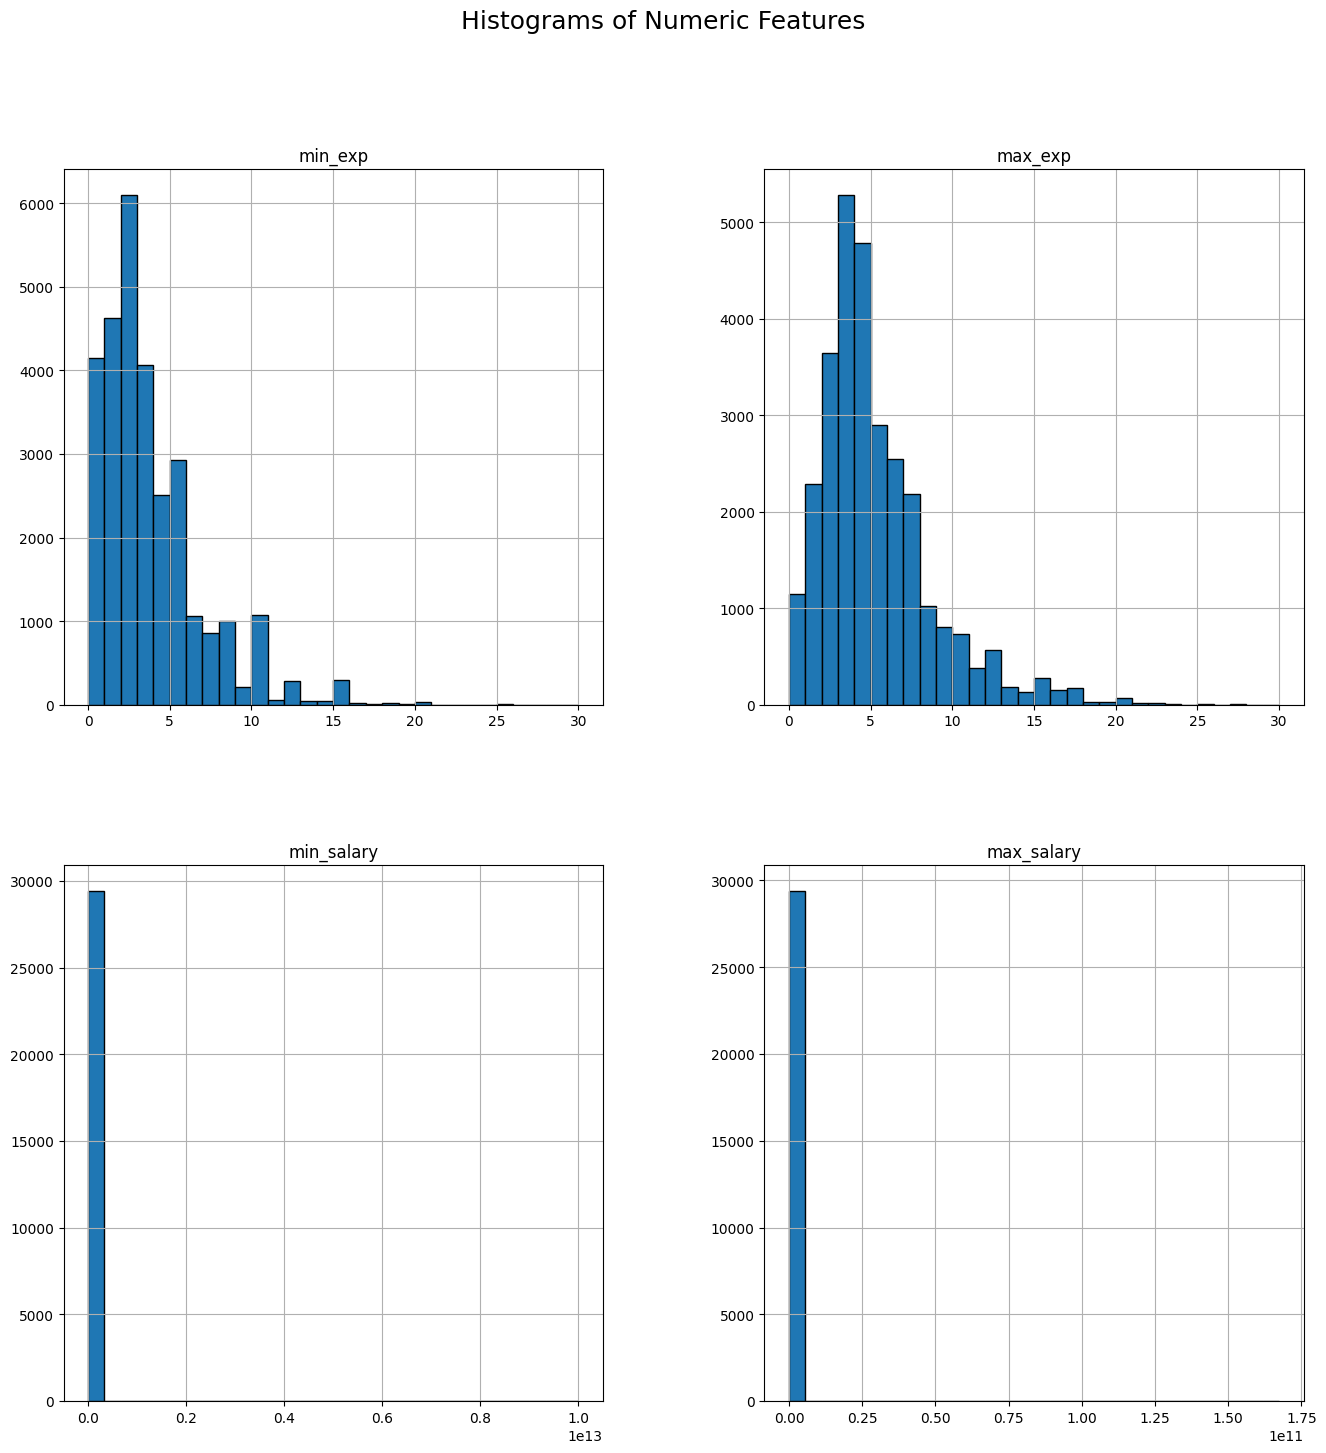

In [265]:
numeric_cols = df.select_dtypes(include=np.number).columns

df[numeric_cols].hist(figsize=(16, 16), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numeric Features", fontsize=18)
plt.show()

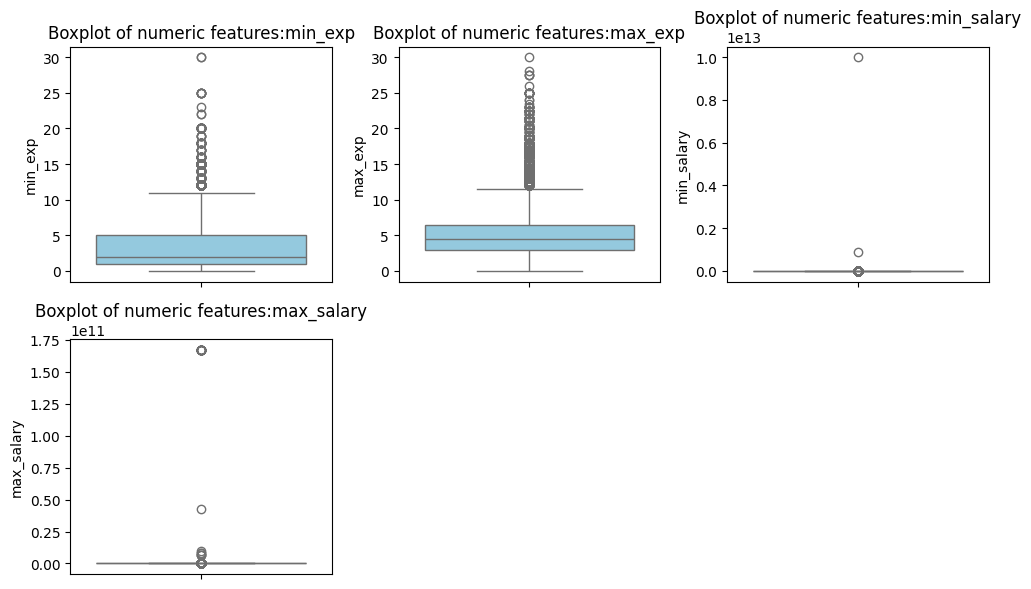

In [266]:
plt.figure(figsize = (10,6))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols)//3+1, 3 , i)
    sns.boxplot(df[col], color = "skyblue")
    plt.title("Boxplot of numeric features:"+ col)

plt.tight_layout()
plt.show()

C:\Users\venut\AppData\Local\Temp\ipykernel_436\4181745622.py:17: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


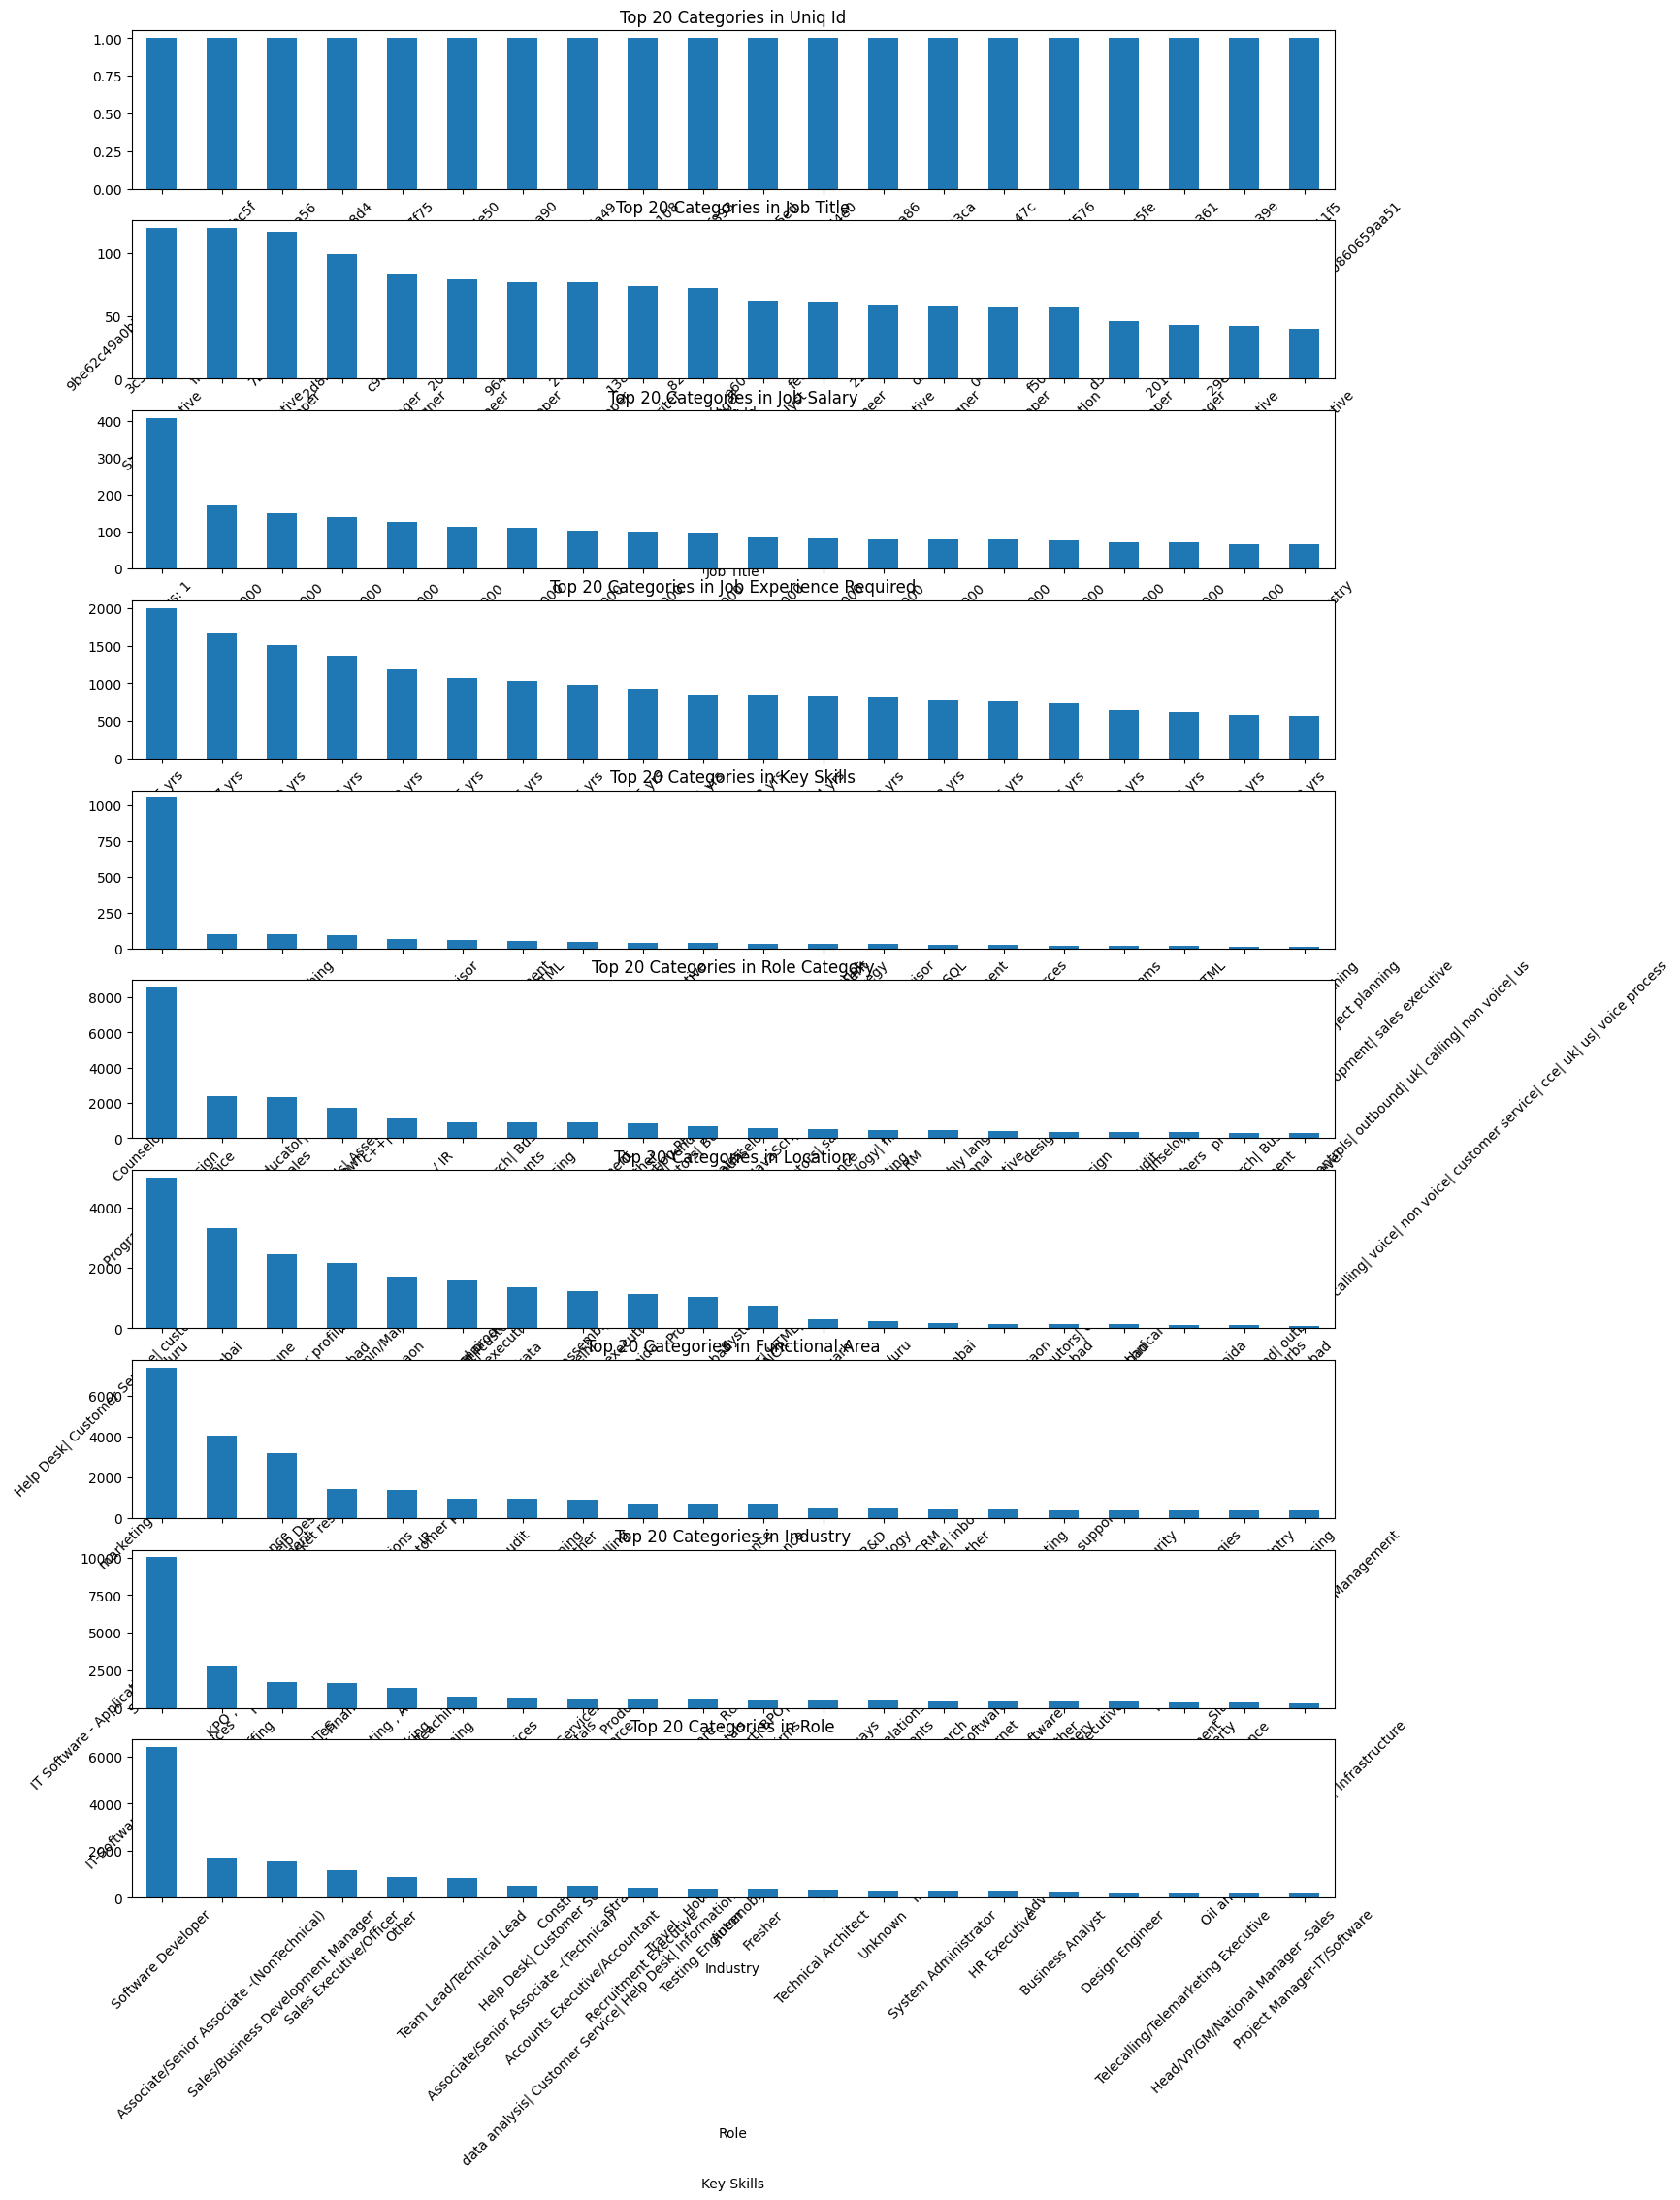

In [267]:
import matplotlib.pyplot as plt

cat_cols = df.select_dtypes(include=['object']).columns

plt.figure(figsize=(16, 25))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(len(cat_cols), 1, i)
    
    # plot only top 20 categories
    top_values = df[col].value_counts().head(20)
    
    top_values.plot(kind='bar')
    plt.title(f"Top 20 Categories in {col}")
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

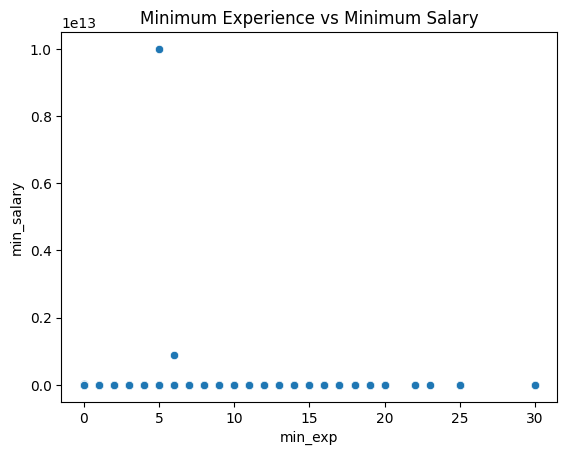

In [268]:
sns.scatterplot(x=df['min_exp'], y=df['min_salary'])
plt.title("Minimum Experience vs Minimum Salary")
plt.show()

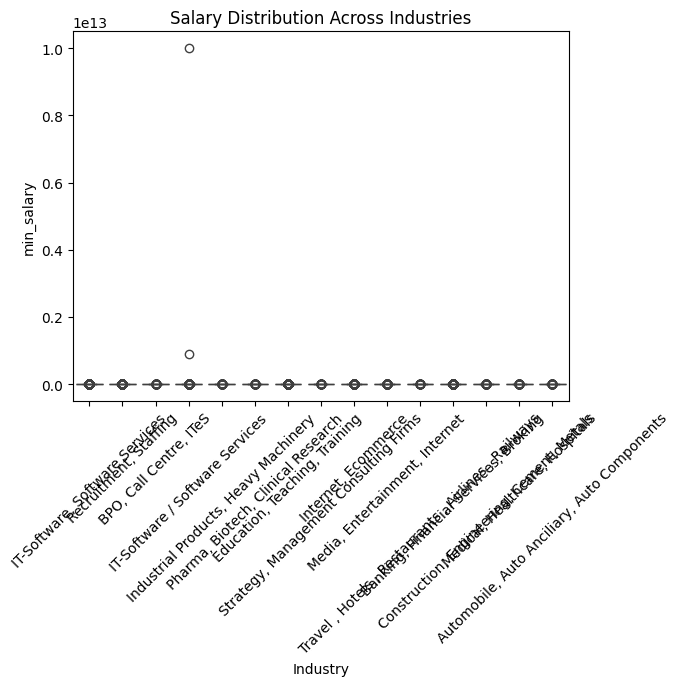

In [269]:
top_industries = df['Industry'].value_counts().head(15).index
sns.boxplot(data=df[df['Industry'].isin(top_industries)], x='Industry', y='min_salary')
plt.xticks(rotation=45)
plt.title("Salary Distribution Across Industries")
plt.show()

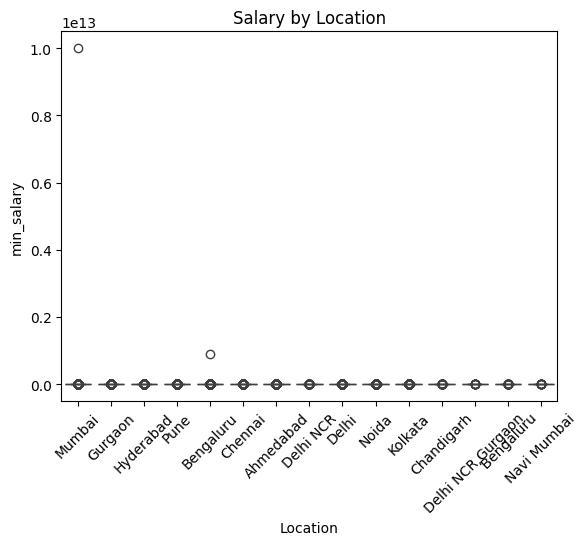

In [270]:
top_locations = df['Location'].value_counts().head(15).index
sns.boxplot(data=df[df['Location'].isin(top_locations)], x='Location', y='min_salary')
plt.xticks(rotation=45)
plt.title("Salary by Location")
plt.show()

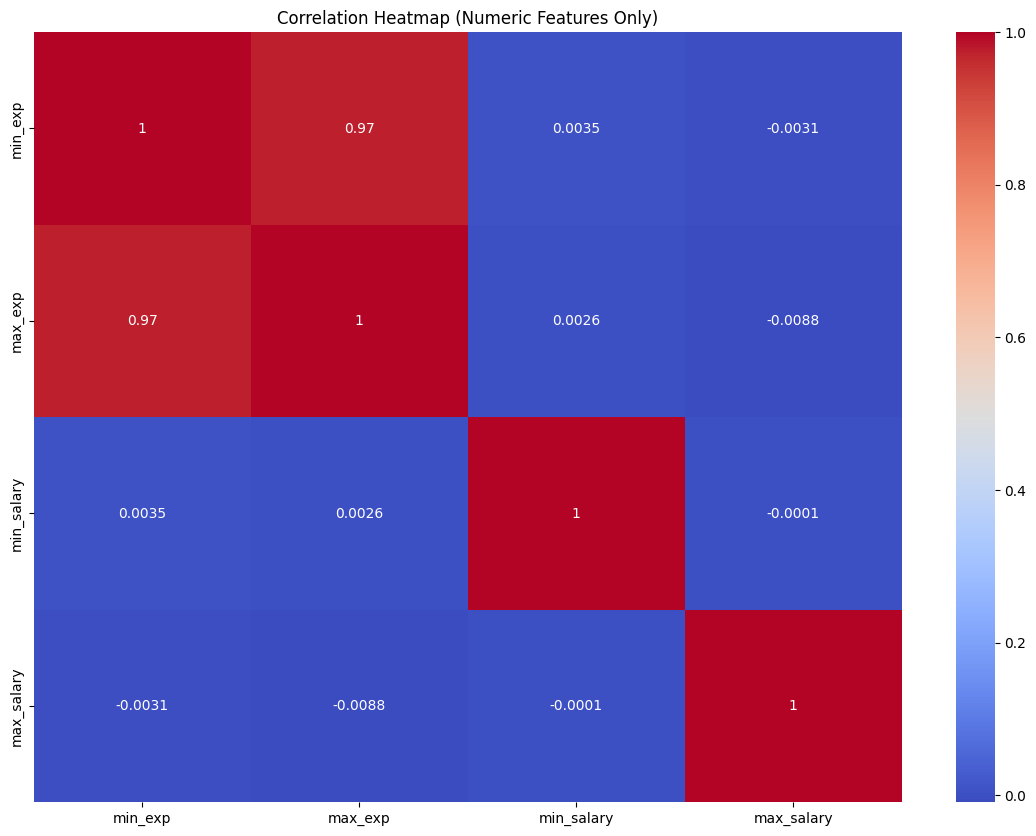

In [271]:
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(14, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()

In [272]:
numeric_df = df.select_dtypes(include=['number'])

corr_s = numeric_df.corr()['min_salary'].sort_values(ascending=False)
print(corr_s)

min_salary    1.000000
min_exp       0.003509
max_exp       0.002585
max_salary   -0.000101
Name: min_salary, dtype: float64


In [273]:

# Outlier capping function
def cap_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df[col] = df[col].clip(lower, upper)

# Apply to numeric columns
num_cols = ['min_exp', 'max_exp', 'min_salary', 'max_salary']

for col in num_cols:
    cap_outliers(col)

In [274]:
df['range_experience'] = df['max_exp'] - df['min_exp']
df['range_experience']

0        2.5
1        1.5
2        0.5
3        2.5
4        1.5
        ... 
29995    1.5
29996    2.0
29997    1.0
29998    2.5
29999    2.5
Name: range_experience, Length: 29418, dtype: float64

In [275]:
df['avg_exp'] = df['min_exp'] + df['max_exp'] / 2
df['avg_exp']

0         8.75
1         3.75
2         0.25
3         1.25
4         3.75
         ...  
29995    14.25
29996     2.50
29997     6.50
29998     8.75
29999     4.25
Name: avg_exp, Length: 29418, dtype: float64

In [276]:
df['salary_range'] = df['max_salary'] - df['min_salary']
df['avg_salary'] = (df['min_salary'] + df['max_salary']) / 2

In [277]:
df['skill_count'] = df['Key Skills'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)

In [278]:
def extract_seniority(title):
    title = str(title).lower()
    if 'senior' in title or 'lead' in title or 'manager' in title:
        return 'senior'
    elif 'junior' in title or 'fresher' in title:
        return 'junior'
    else:
        return 'mid'

df['seniority'] = df['Job Title'].apply(extract_seniority)

In [279]:
df['city'] = df['Location'].str.split(',').str[0]

In [280]:
df['is_remote'] = df['Location'].apply(lambda x: 1 if 'remote' in str(x).lower() else 0)
df['is_remote']

0        0
1        0
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    0
29998    0
29999    0
Name: is_remote, Length: 29418, dtype: int64

In [281]:
print(df[['min_salary','max_salary']].dtypes)
print("Sample min_salary unique values (first 20):", df['min_salary'].astype(str).unique()[:20])

mask = df['min_salary'].apply(lambda x: isinstance(x, str))
print("Rows where min_salary is string:", df[mask].head(10))

print("Any 'not disclosed' variants in Job Salary column (case-insensitive):",
      df['Job Salary'].astype(str).str.lower().str.contains('not disclosed').sum())


min_salary    float64
max_salary    float64
dtype: object
Sample min_salary unique values (first 20): ['0.0' '200000.0' '250000.0' '1.0' '100000.0' '150000.0' '175000.0'
 '225000.0' '50000.0' '125000.0' '60000.0' '2.0' '80000.0' '67700.0'
 '90000.0' '5.0' '211.0' '16.0' '30.0' '37400.0']
Rows where min_salary is string: Empty DataFrame
Columns: [Uniq Id, Crawl Timestamp, Job Title, Job Salary, Job Experience Required, Key Skills, Role Category, Location, Functional Area, Industry, Role, min_exp, max_exp, min_salary, max_salary, range_experience, avg_exp, salary_range, avg_salary, skill_count, seniority, city, is_remote]
Index: []

[0 rows x 23 columns]
Any 'not disclosed' variants in Job Salary column (case-insensitive): 0


In [289]:
# 1. DROP IRRELEVANT COLUMNS
# ------------------------------
df_model = df.copy()

df_model = df_model.drop([
    'Uniq Id',
    'Crawl Timestamp',
    'Job Title',
    'Key Skills',
    'Job Experience Required',
    'Location',
    'Role',
    'Job Salary'
], axis=1)

In [290]:
# 2. ONE-HOT ENCODE CATEGORICAL COLUMNS
# ------------------------------
categorical_cols = ['Industry', 'Functional Area', 'city', 'Role Category', 'seniority']
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)


In [291]:
# 3. DEFINE FEATURES AND TARGET
# ------------------------------
X = df_model.drop('avg_salary', axis=1)
y = df_model['avg_salary']


In [292]:
# 4. TRAIN–TEST SPLIT
# ------------------------------
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [293]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [294]:
lr = LinearRegression()
lr.fit(Xtrain,ytrain)

ytrain_pred = lr.predict(Xtrain)
ytest_pred = lr.predict(Xtest)

In [295]:
mae = mean_absolute_error(ytest, ytest_pred)
mse = mean_squared_error(ytest, ytest_pred)
rmse = np.sqrt(mse)
r2 = r2_score(ytest, ytest_pred)

print("mean absolute error :", mae)
print("mean sqauared error :",mse)
print("root mean square error :", rmse)
print("R2 score ;", r2)

mean absolute error : 6.229752695610537e-10
mean sqauared error : 6.078860093426496e-19
root mean square error : 7.796704491916118e-10
R2 score ; 1.0


In [296]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [297]:
result = {}

dt = DecisionTreeRegressor(random_state=42)
dt.fit(Xtrain, ytrain)
ytest_pred_dt = dt.predict(Xtest)
result['Decision Tree'] = np.sqrt(mean_squared_error(ytest, ytest_pred_dt))



rf = RandomForestRegressor(n_estimators=200,random_state = 42)
rf.fit(Xtrain, ytrain)
ytest_pred_rf = rf.predict(Xtest)
result['Random Forest'] = np.sqrt(mean_squared_error(ytest, ytest_pred_rf))


gb = GradientBoostingRegressor(random_state = 42)
gb.fit(Xtrain, ytrain)
ytest_pred_gb = gb.predict(Xtest)
result['Gradient Boosting'] = np.sqrt(mean_squared_error(ytest, ytest_pred_gb))


print("Model Performance (RMSE):")
for model, rmse in result.items():
    print(f"{model}: {rmse}")

Model Performance (RMSE):
Decision Tree: 690.5936648396967
Random Forest: 755.5033605242764
Gradient Boosting: 745.7601707172729


In [298]:
from sklearn.model_selection import GridSearchCV

In [299]:
dt_params = { "max_depth":[5, 10, 15, 20, None],
               "min_samples_split": [2,5,10],
               "min_samples_leaf" : [1, 2, 5]}

dt_grid = GridSearchCV(dt, dt_params, cv = 3, scoring='neg_mean_squared_error', n_jobs=-1)
dt_grid.fit(Xtrain, ytrain)

print("Best parameters for Decision Tree : ", dt_grid.best_params_)
print("Best RMSE for DEcision Tree after Hyperparameter Tuning : ", (-dt_grid.best_score_)**0.5)

Best parameters for Decision Tree :  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best RMSE for DEcision Tree after Hyperparameter Tuning :  770.1611951332632


In [300]:
rf_params = { "n_estimators":[100,200],
             "max_depth": [10, 20, None],
             "min_samples_split":[2,5,],
             "min_samples_leaf":[1,2]}

rf_grid = GridSearchCV(rf, rf_params, cv = 3, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(Xtrain, ytrain)

print("Best parameters for Random Forest:", rf_grid.best_params_)
print("Best RMSE for Random Forest after Hyperparameter Tuning: ", (-rf_grid.best_score_)**0.5)

Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE for Random Forest after Hyperparameter Tuning:  777.3664322303614


In [301]:
gb_params = {"n_estimators": [100, 200],
             "learning_rate": [0.01, 0.1, 0.2],
             "max_depth": [3, 5, 7]}


gb_grid = GridSearchCV(gb, gb_params, cv= 3 , scoring = 'neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(Xtrain,ytrain)

print("Best parameters for Gradient Boosting:", gb_grid.best_params_)
print("Best RMSE for Gradient Boosting after Hyperparameter Tuning:", (-gb_grid.best_score_)**0.5)

Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Best RMSE for Gradient Boosting after Hyperparameter Tuning: 571.3655057555411


In [302]:
best_gb = GradientBoostingRegressor(
    n_estimators = 200,
    learning_rate = 0.2,
    max_depth = 3,
    random_state=42
)

best_gb.fit(Xtrain, ytrain)

,loss,'squared_error'
,learning_rate,0.2
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [303]:
y_pred = best_gb.predict(Xtest)

final_rmse = np.sqrt(mean_squared_error(ytest, y_pred))
print("Final RMSE on Test Set with Tuned Gradient Boosting:", final_rmse)

Final RMSE on Test Set with Tuned Gradient Boosting: 510.1381146848793


In [307]:
import joblib

joblib.dump(best_gb, 'job_salary_prediction_model.pkl')
print("Model saved as final_gb_model.pkl")

Model saved as final_gb_model.pkl


In [308]:
# Save final columns after training
final_columns = Xtrain.columns.tolist()

import joblib
joblib.dump(final_columns, "model_columns.pkl")

['model_columns.pkl']

In [309]:
df.columns.tolist()

['Uniq Id',
 'Crawl Timestamp',
 'Job Title',
 'Job Salary',
 'Job Experience Required',
 'Key Skills',
 'Role Category',
 'Location',
 'Functional Area',
 'Industry',
 'Role',
 'min_exp',
 'max_exp',
 'min_salary',
 'max_salary',
 'range_experience',
 'avg_exp',
 'salary_range',
 'avg_salary',
 'skill_count',
 'seniority',
 'city',
 'is_remote']

In [ ]:
df_rec = df.copy()

# Combine important textual features
df_rec["combined_text"] = (
    df_rec["Job Title"].fillna("") + " " +
    df_rec["Key Skills"].fillna("") + " " +
    df_rec["Functional Area"].fillna("") + " " +
    df_rec["Industry"].fillna("") + " " +
    df_rec["Role"].fillna("") + " " +
    df_rec["city"].fillna("")
)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
tfidf_matrix = tfidf.fit_transform(df_rec["combined_text"])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tfidf_matrix)

In [ ]:
import joblib

joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(similarity_matrix, "job_similarity_matrix.pkl")
joblib.dump(df_rec, "recommendation_data.pkl")

print("Recommendation system files saved!")